## Argoverse Inverse Perspective Mapping (IPM) Tutorial
In recent work at CVPR 2020, researchers from Cambridge used Argoverse for a semantic map automation task [[paper link]](https://arxiv.org/abs/2003.13402). A simple baseline they introduce is to warp semantic segmentation predictions onto a bird's eye view (BEV) for semantic occupancy grid mapping [1].

We show here how monocular image data from Argoverse can be projected to the BEV using `argoverse-api` tools.

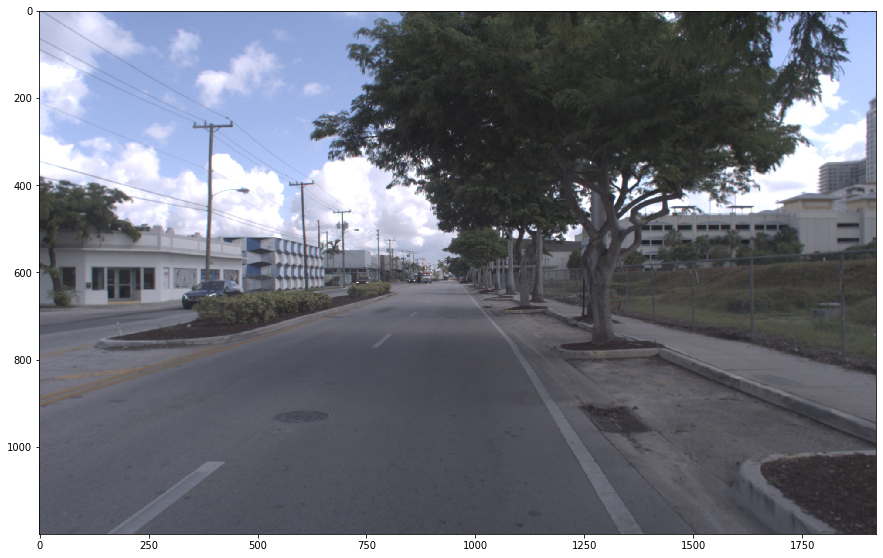

In [6]:
import imageio
import matplotlib.pyplot as plt

# cam_timestamp = '315969629422114600'
# log_id = '00c561b9-2057-358d-82c6-5b06d76cebcf'

cam_timestamp = '315973061557317752'
log_id = 'c9d6ebeb-be15-3df8-b6f1-5575bea8e6b9'

ARGOVERSE_DATA_ROOT = '/Users/johnlamb/Downloads/ARGOVERSE-COMPETITION/val/argoverse-tracking'
camera_name = 'ring_front_center'

split_data_dir = f'{ARGOVERSE_DATA_ROOT}/val'
img_fpath = f'{split_data_dir}/{log_id}/{camera_name}/{camera_name}_{cam_timestamp}.jpg'
img_front = imageio.imread(img_fpath)

fig = plt.figure(figsize=(15,10))
plt.imshow(img_front)
plt.show()

In IPM, we assume the ground is perfectly flat, such that all ground/road points lie upon a plane $\pi$. For a calibrated camera $P = K[R \mid t]$, world points $\mathbf{X}$ are brought into the image frame using the projection matrix $P$:

$$
P = K \begin{bmatrix} | & | & | & | \\ \mathbf{r}_1 & \mathbf{r}_2 & \mathbf{r}_3 & \mathbf{t} \\ | & | & | & | \end{bmatrix}
$$

We choose our world coordinate frame to lie on the ground, and thus the $z$-coordinate of all road points is equal to zero. We can express the projection of world point $X$ into the image as $x_{image} = P \mathbf{X}$, where

$$
x_{image} = \begin{bmatrix} | & | & | & | \\ \mathbf{p}_1 & \mathbf{p}_2 & \mathbf{p}_3 & \mathbf{p}_4 \\ | & | & | & | \end{bmatrix} \begin{bmatrix} X & Y & 0 & 1 \end{bmatrix}^{\top}
$$

Simplifying,
$$ x_{image} = \begin{bmatrix} | & | & | \\\mathbf{p}_1 & \mathbf{p}_2 & \mathbf{p}_4 \\ | & | & | \end{bmatrix} \begin{bmatrix} X & Y & 1 \end{bmatrix}^{\top}
$$

In other words, points on the ground plane can be projected to the image plane using a simple $3 \times 3$  homography matrix. We can compute the IPM homography $H$ as follows. Consider the columns $\mathbf{r}_i$ of a rotation matrix:
$$
{}^{camera}R_{ground} = \begin{bmatrix} | & | & | \\ \mathbf{r}_1 & \mathbf{r}_2 & \mathbf{r}_3 \\ | & | & | \end{bmatrix}
$$
Its first two columns form the first two columns of the desired IPM homography:
$$
{}^{image}H_{ground} = K\begin{bmatrix} | & | & | \\ \mathbf{r}_1 & \mathbf{r}_2 & \mathbf{t} \\ | & | & | \end{bmatrix}
$$

we want its inverse, which takes a point in the image frame, and brings it into the road frame:

$$
\begin{aligned} \mathbf{x}_{ground} &= {}^{ground}H_{image}\mathbf{x}_{image}  \\ \mathbf{x}_{ground} &= {}^{image}H_{ground}^{-1} \mathbf{x}_{image} \end{aligned}
$$

You can read more about this in Section 8.1.1 of Hartley & Zisserman [2]. In Numpy, we create this homography as follows:

In [3]:
import numpy as np

from argoverse.utils.se3 import SE3

def homography_from_calibration(camera_SE3_ground: SE3, K: np.ndarray) -> np.ndarray:
    """
    See Hartley Zisserman, Section 8.1.1
    """
    r1 = camera_SE3_ground.transform_matrix[:3,0].reshape(-1,1)
    r2 = camera_SE3_ground.transform_matrix[:3,1].reshape(-1,1)
    t =  camera_SE3_ground.transform_matrix[:3,3].reshape(-1,1)
    
    img_H_ground = K.dot(np.hstack([r1,r2,t]))
    return img_H_ground

We will load the camera calibration data as follows:

In [8]:
import cv2
import numpy as np

import argoverse 
from argoverse.utils.se3 import SE3
from argoverse.data_loading.simple_track_dataloader import SimpleArgoverseTrackingDataLoader
from argoverse.utils.calibration import get_calibration_config

dl = SimpleArgoverseTrackingDataLoader(data_dir=split_data_dir, labels_dir=split_data_dir)
city = dl.get_city_name(log_id)
city_SE3_egovehicle = dl.get_city_to_egovehicle_se3(log_id, cam_timestamp)
calib_data = dl.get_log_calibration_data(log_id)
camera_config = get_calibration_config(calib_data, camera_name)

camera_SE3_egovehicle = camera_config.extrinsic
camera_R_egovehicle = camera_SE3_egovehicle[:3,:3]
camera_t_egovehicle = camera_SE3_egovehicle[:3,3]
camera_SE3_egovehicle = SE3(rotation=camera_R_egovehicle, translation=camera_t_egovehicle)
# Extract 3x3 intrinsics matrix
K = camera_config.intrinsic[:,:3]

We'll now chain together two SE(3) transformations: from ground -> egovehicle, and from egovehicle -> front camera:

$$ {}^{camera}T_{ground} = {}^{camera}T_{egovehicle} \circ {}^{egovehicle}T_{ground}$$

The egovehicle's coordinate frame origin lies at the center of the rear axle, which is 33 cm above the ground: 

In [ ]:
AXLE_HEIGHT_FROM_GROUND = 0.33 # in meters, 
ground_SE3_egovehicle = SE3(rotation=np.eye(3), translation=np.array([0,0,AXLE_HEIGHT_FROM_GROUND]))
egovehicle_SE3_ground = ground_SE3_egovehicle.inverse()
camera_SE3_ground = camera_SE3_egovehicle.right_multiply_with_se3(egovehicle_SE3_ground)

Since we want a higher resolution than 1 meter/px, we compose the homography with another homography to rescale to a higher resolution. We'll also shift the image so that points with negative $y$ value (i.e. on the right if car is facing forward) gain positive $y$ values, and thus appear in our BEV image.

In [9]:
img_H_ground = homography_from_calibration(camera_SE3_ground, K)
ground_H_img = np.linalg.inv(img_H_ground)

LATERAL_EXTENT = 20 # look 20 meters left and right
FORWARD_EXTENT = 40 # look 40 meters ahead

resolution = 0.01 # in meters/px
out_width = int(FORWARD_EXTENT / resolution)
out_height = int(LATERAL_EXTENT*2 / resolution)

RESCALING = int(1/resolution) # pixels/meter, if rescaling=1, then 1 px/1 meter
SHIFT = int(out_width//2)
shiftedground_H_ground = np.array(
    [
        [RESCALING,0,0],
        [0,RESCALING,SHIFT],
        [0,0,1]
    ])
shiftedground_H_img = shiftedground_H_ground.dot(ground_H_img)
# We use OpenCV to perform the interpolation needed during warping:
bev_img = cv2.warpPerspective(img_front, shiftedground_H_img, dsize=(out_width, out_height))

Indeed, we find that all 3 homography matrices computed above have rank 3:

In [12]:
print('H Rank: ', np.linalg.matrix_rank(img_H_ground))
print('H Rank: ', np.linalg.matrix_rank(ground_H_img))
print('H Rank: ', np.linalg.matrix_rank(shiftedground_H_ground))

H Rank:  3
H Rank:  3
H Rank:  3


Now, we'll visualize the results. It should be clear that the BEV is nothing more than a distorted/stretched version of the frontal camera view:

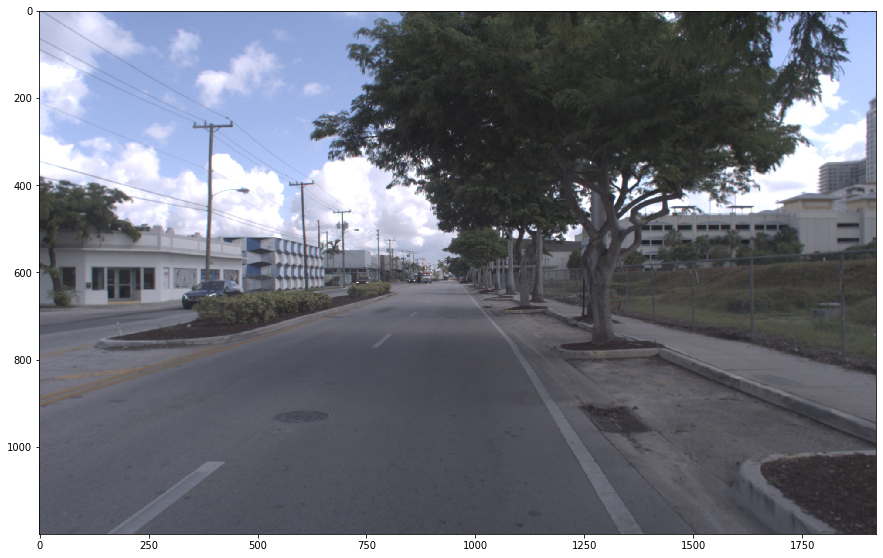

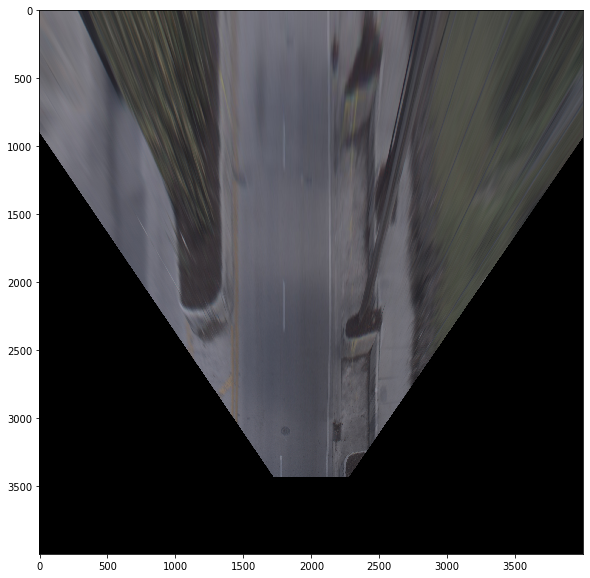

In [10]:
import scipy.ndimage

fig = plt.figure(figsize=(15,10))
plt.imshow(img_front)
plt.show()

fig = plt.figure(figsize=(15,10))
bev_img = np.flipud(bev_img)
bev_img = scipy.ndimage.rotate(bev_img, angle=90)
plt.imshow(bev_img)
plt.show()

## References

1. Thomas Roddick and Roberto Cipolla. *Predicting Semantic Map Representations From Images Using Pyramid Occupancy Networks*. In *CVPR*, 2020.

2. Richard I. Hartley and Andrew Zisserman. *Multiple View Geometry in Computer Vision*. Cambridge University Press,
ISBN: 0521540518, second edition, 2004. 